In [89]:
import pandas as pd
import numpy as np
import requests
import re 
import matplotlib.pyplot as plt
import itertools
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix, auc
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import metrics
pd.options.mode.chained_assignment = None  # default='warn'

### Fetch Data

In [2]:
# Define the API endpoint and parameters
url = "https://data.cityofchicago.org/resource/cwig-ma7x.json"

# Fetch the total count of records
def get_total_count(url):
    params = {
        "$select": "count(*)"
    }
    response = requests.get(url, params=params)
    data = response.json()
    return int(data[0]['count'])

total_count = get_total_count(url)
print(f"Total number of records available: {total_count:,.0f}")

Total number of records available: 266,925


In [3]:
# Fetch data and load it into a pandas DataFrame
def fetch_data(url, params):
    response = requests.get(url, params=params)
    data = response.json()
    return pd.DataFrame(data)

# Set the limit parameter equal to the number of available records
params = {
    "$limit": total_count
}

# Fetch the data and load it into a DataFrame
df = fetch_data(url, params)

print(f'Number of records retrieved: {df.shape[0]:,.0f}')

Number of records retrieved: 266,925


In [4]:
# Check data
df.head(5)

,inspection_id,dba_name,aka_name,license_,facility_type,risk,address,city,state,zip,...,results,latitude,longitude,location,:@computed_region_awaf_s7ux,:@computed_region_6mkv_f3dw,:@computed_region_vrxf_vc4k,:@computed_region_bdys_3d7i,:@computed_region_43wa_7qmu,violations
0,2588651,HUDSON NONSTOP,HUDSON (T3/K1),2951445,Grocery Store,Risk 3 (Low),10000 W OHARE ST,CHICAGO,IL,60666,...,Pass,41.97620113902387,-87.90530912510346,"{'type': 'Point', 'coordinates': [-87.90530912...",34,16197,75,668,29,NaN
1,2588660,"24 HRS GYROS & SUB INC.,",24 HRS GYROS & SUB,2192751,Restaurant,Risk 1 (High),2058 E 71ST ST,CHICAGO,IL,60649,...,Pass,41.7663726804721,-87.57391936361535,"{'type': 'Point', 'coordinates': [-87.57391936...",32,22538,39,152,33,"55. PHYSICAL FACILITIES INSTALLED, MAINTAINED ..."
2,2588682,JOJIGYROS786 INC,JOJI GYROS,2749497,Restaurant,Risk 1 (High),2518 E 79TH ST,CHICAGO,IL,60649,...,No Entry,41.751883323857825,-87.56299535958054,"{'type': 'Point', 'coordinates': [-87.56299535...",43,22538,39,246,37,NaN
3,2588672,THE BATON SHOW LOUNGE,THE BATON SHOW LOUNGE,2732892,Restaurant,Risk 1 (High),4703-4713 N BROADWAY,CHICAGO,IL,60640,...,No Entry,41.9673635873824,-87.65856734441053,"{'type': 'Point', 'coordinates': [-87.65856734...",40,22616,31,241,39,NaN
4,2588681,"CHICAGO SHARK FISH, INC","CHICAGO SHARK FISH, INC",2483042,Restaurant,Risk 2 (Medium),9800 S HALSTED ST,CHICAGO,IL,60628,...,Out of Business,41.71587020321599,-87.64321013954779,"{'type': 'Point', 'coordinates': [-87.64321013...",18,21861,72,592,22,NaN


### Data Cleaning

In [77]:
# Print unique values in results and find out Fail represents failed inspection
distinct_strings = df['results'].unique()
distinct_strings

array(['Pass', 'No Entry', 'Out of Business', 'Fail',
       'Pass w/ Conditions', 'Not Ready', 'Business Not Located'],
      dtype=object)

In [78]:
df_cleaned = df[df['results'].isin(['Fail', 'Pass'])]

In [79]:
# Check how many rows having Nan value
df_cleaned['violations'].isna().sum()

36473

In [80]:
# Drop the Nan values
df_cleaned = df_cleaned.dropna(subset=['violations'])

In [81]:
# Function to separate descriptions and comments
def separate_violations(violations):
    pattern = r'(?:\| \d+\.\s|\A\d+\.\s)(.*?)(?:\s-\sComments: ([^|]*)|(?=\s*\|\s*\d+\.|$))'
    descriptions = []
    comments = []

    for match in re.finditer(pattern, violations):
        descriptions.append(match.group(1))
        if match.group(2):
            comments.append(match.group(2))

    return descriptions, comments

df_cleaned[['violation_description', 'comments']] = df_cleaned.apply(
    lambda x: separate_violations(x['violations']), axis=1, result_type='expand'
)

In [75]:
# Drop any rows don't have a comment
df_cleaned = df_cleaned.dropna(subset=['comments'])

In [82]:
df_cleaned.groupby("results").count()

,inspection_id,dba_name,aka_name,license_,facility_type,risk,address,city,state,zip,...,longitude,location,:@computed_region_awaf_s7ux,:@computed_region_6mkv_f3dw,:@computed_region_vrxf_vc4k,:@computed_region_bdys_3d7i,:@computed_region_43wa_7qmu,violations,violation_description,comments
results,,,,,,,,,,,,,,,,,,,,,
Fail,48679,48679,48215,48676,48635,48678,48679,48652,48668,48673,...,48512,48512,48109,48512,48109,48504,48109,48679,48679,48679
Pass,104403,104403,103915,104397,104340,104402,104403,104370,104396,104395,...,104016,104016,102106,104016,102106,103997,102106,104403,104403,104403


In [93]:
# balance the data
df_cleaned = df_cleaned.groupby("results").sample(n=20000, random_state=1)
df_cleaned.reset_index(inplace=True, drop=True)

In [94]:
# convert label to a binary numerical variable
df_cleaned['results_flag'] = df_cleaned.results.map({'Pass':0, 'Fail':1})

In [95]:
# define X and y
X = df_cleaned.comments
y = df_cleaned.results_flag

print(f"X Shape: {X.shape}")
print(f"y Shape: {y.shape}")

X Shape: (40000,)
y Shape: (40000,)


In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(f"Training records, X_train: {X_train.shape} y_train: {y_train.shape}")
print(f"Testing records, X_test: {X_test.shape} y_test: {y_test.shape}")

Training records, X_train: (30000,) y_train: (30000,)
Testing records, X_test: (10000,) y_test: (10000,)


In [97]:
# Convert list of comments into a single string per row
X_train = X_train.apply(lambda x: ' '.join(x))
X_test = X_test.apply(lambda x: ' '.join(x))

The data cleaning aims to filter out the data that belongs to either Fail or Pass to train binary models. Firstly, it uses Regex to extract the comments from "violations" preparing for predictors. Then it drops any data that doesn't have a comment, in other words, the X would be Nah. Then it ensures the data of two classes are evenly separately, resulted in 20000 for each of class. Finally, split the data into 75% training data and 25% testing data.


### Vectorize Data

In [62]:
vect = CountVectorizer(lowercase=True, stop_words='english',
                                  max_df=0.8, min_df=0.2, max_features=100, ngram_range=(1,4))

In [63]:
# Fit and transform X_train
X_train_dtm = vect.fit_transform(X_train)
# Fit and transform X_test
X_test_dtm = vect.transform(X_test)

* Firstly, lowercase=True ensures that all text is converted to lowercase, which helps in maintaining consistency and reducing feature space as words with different cases (like "Hello" and "hello") are treated the same. 
* The inclusion of stop_words='english' removes common English words (like 'the', 'is', 'at') that usually don't contribute to the predictive power of the model due to their high frequency and low informational content. 
* Setting max_df=0.8 and min_df=0.2 is a way to filter out words that appear too frequently or infrequently; this helps in excluding words that are either too common across all comments (more than 80% of the documents, for example, a specific code appearing in the start of comment) or too rare (less than 20% of the documents), thereby focusing on words that are more likely to be relevant in distinguishing between different comments. 
* The max_features=100 limits the number of features to the top 100, which can be useful for reducing dimensionality and computational load, making the model more efficient. Lastly, ngram_range=(1,4) enables the model to consider not only individual words (unigrams) but also combinations of up to 4 contiguous words (bigrams, trigrams, and four-grams), capturing more context and potentially improving the model's ability to understand and predict based on the comments.

### Train a Binary Model

In [45]:
# instantiate a Multinomial Naive Bayes model
nb = MultinomialNB()

In [115]:
nb.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': 'warn'}

In [105]:
nb.fit(X_train_dtm, y_train)

MultinomialNB()

In [106]:
y_pred_class = nb.predict(X_test_dtm)

In [107]:
print(f"Test Accuracy: {metrics.accuracy_score(y_test, y_pred_class) * 100:.1f}%")

Test Accuracy: 88.0%


In [108]:
# calculate precision and recall
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      5002
           1       0.89      0.87      0.88      4998

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000


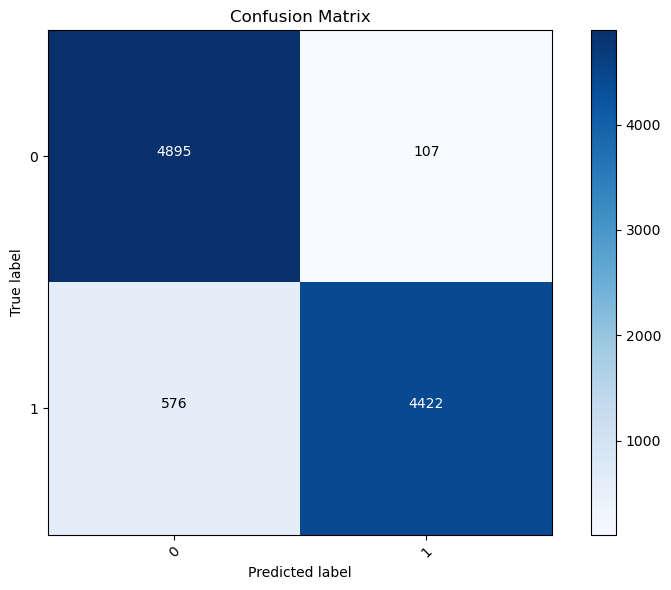

In [90]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_class)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test), rotation=45)
plt.yticks(tick_marks, np.unique(y_test))

# Labeling the plot
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [116]:
# instantiate a SVM model
svm = SGDClassifier(max_iter=200, tol=None)

In [117]:
# train the model using X_train_dtm
svm.fit(X_train_dtm, y_train)

SGDClassifier(max_iter=200, tol=None)

In [118]:
# make class predictions for X_test_dtm
y_pred_class = svm.predict(X_test_dtm)

In [119]:
# calculate accuracy of class predictions
print(metrics.accuracy_score(y_test, y_pred_class))

0.9345


In [120]:
# calculate precision and recall
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      5002
           1       0.96      0.90      0.93      4998

    accuracy                           0.93     10000
   macro avg       0.94      0.93      0.93     10000
weighted avg       0.94      0.93      0.93     10000


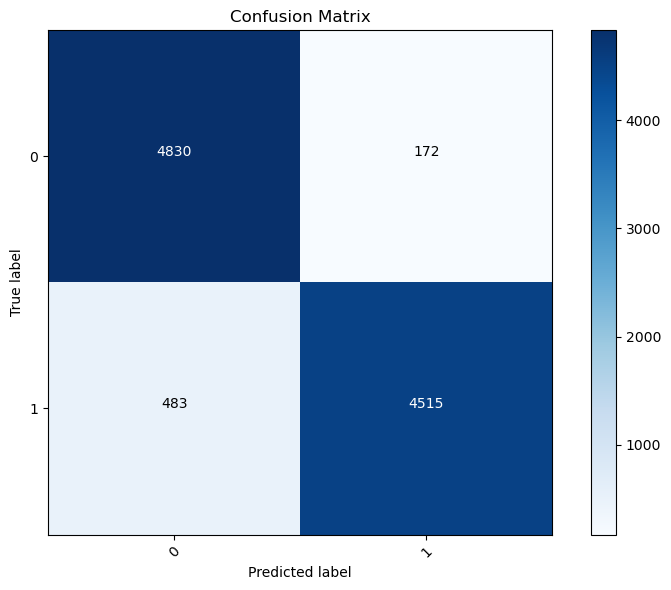

In [121]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_class)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test), rotation=45)
plt.yticks(tick_marks, np.unique(y_test))

# Labeling the plot
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

Based on the graphs and metrics, the SVM model is more robust than the NaiveBayes model. It has higher scores in all key metrics: 
* SVM shows a significantly higher accuracy compared to NaiveBayes, indicating that it correctly classified a larger proportion of the total instances.
* A higher precision, as seen in SVM, indicates that a higher proportion of instances classified as positive were actually positive. This is crucial in scenarios where false positives are a greater concern.
* SVM's higher recall rate implies that it is better at detecting the positive cases and misses fewer actual positives compared to NaiveBayes. This metric is important in situations where missing out on actual positives (false negatives) is costly.
* The F1-Score provides a balance between precision and recall. It is particularly useful when the cost of false positives and false negatives is unclear or when there is an uneven class distribution. SVM's higher F1-Score suggests it maintains a better balance between recall and precision.